In [2]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

Load data.

In [3]:
df_ratings = pd.read_table("datasets.imdbws.com/title.ratings.tsv.gz",compression='gzip',sep='\t', low_memory=False)
df_basics = pd.read_table("datasets.imdbws.com/title.basics.tsv.gz",compression='gzip',sep='\t', low_memory=False)
df_akas = pd.read_table("datasets.imdbws.com/title.akas.tsv.gz",compression='gzip',sep='\t', low_memory=False)
df_crew = pd.read_table("datasets.imdbws.com/title.crew.tsv.gz",compression='gzip',sep='\t', low_memory=False)

Preprocess data.

In [4]:
# Count how many times the movie has been translated
df_translations = df_akas.groupby(['titleId']).size().reset_index(name='counts')
df_translations.columns = ['tconst', 'numTranslations']

# Join data frames together
df_joined = df_ratings.join(df_basics.set_index('tconst'),on='tconst').join(
            df_translations.set_index('tconst'),on='tconst').join(
            df_crew.set_index('tconst'),on='tconst')

# Drop rows where there is missing information
df_complete_data = df_joined[df_joined['titleType'].str.contains("movie")]
df_clean_up = df_complete_data[df_complete_data.runtimeMinutes.str.contains("\N") == False]
df_clean_up = df_clean_up[df_clean_up.directors.str.contains("\N") == False]
df_clean_up = df_clean_up[df_clean_up.writers.str.contains("\N") == False]

# Drop columns that don't hold any information
df_clean = df_clean_up.drop(['titleType', 'primaryTitle', 'directors',
                             'writers', 'originalTitle', 'endYear',
                             'isAdult', 'tconst'], axis=1)

# Count number times the director and writer have directed/written movies in dataset
directorPopularity = df_clean_up['directors'].value_counts().to_dict()
df_clean['directorPopularity'] = df_clean_up['directors'].map(directorPopularity)
writerPopularity = df_clean_up['writers'].value_counts().to_dict()
df_clean['writerPopularity'] = df_clean_up['writers'].map(writerPopularity)

# One hot encoding for movie genres
genre_dummies = df_clean['genres'].str.get_dummies(sep=',')
df_one_hot_encoding = df_clean.join(genre_dummies)

In [5]:
# Final clean up, drop irrelevant information, fill NaN values with 0
# Make sure all data is in correct numerical format
data = df_one_hot_encoding.drop(['genres'], axis = 1).fillna(0).reset_index(
                                drop=True).apply(pd.to_numeric, errors='coerce').dropna()

# Split data into features and target value (movie rating)
X = data.drop('averageRating', axis = 1)
y = data['averageRating']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Create and train decision tree.

In [6]:
tree = DecisionTreeRegressor(max_depth = 11)  
tree.fit(X_train, y_train) 

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Predict ratings.

In [7]:
y_pred = tree.predict(X_test) 

In [8]:
def loss(y_test, y_predict):
    return np.sum(abs(y_test-y_predict))/len(y_test)

print ('Average distance from correct rating:', loss(y_test,y_pred))

('Average distance from correct rating:', 0.8481829793548331)


Visualization for tree of depth 3.

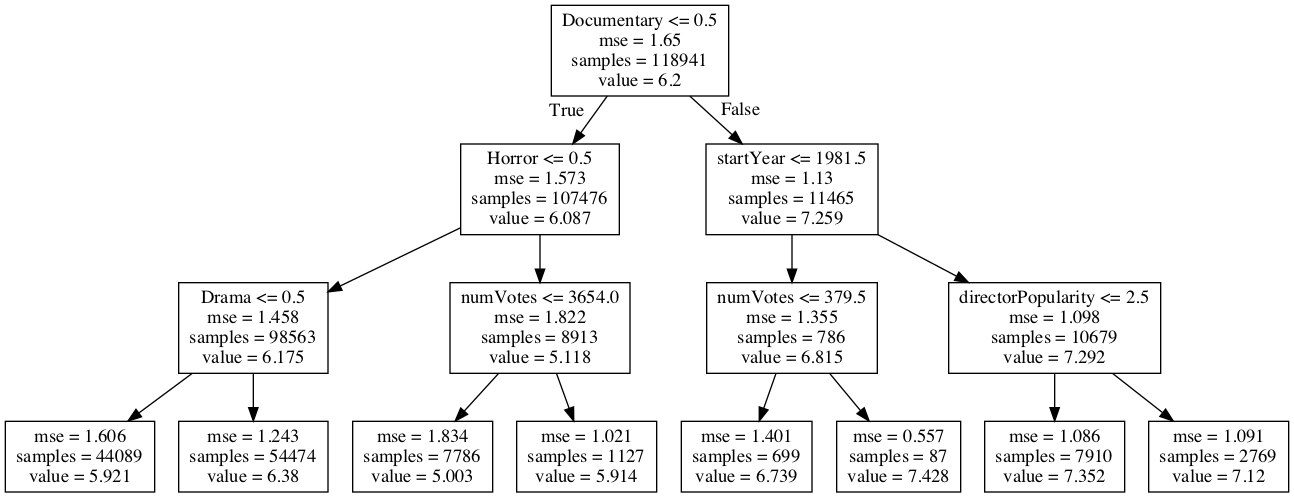

In [9]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

visualization_tree = DecisionTreeRegressor(max_depth = 3)
visualization_tree.fit(X_train, y_train) 
dot_data = StringIO()
export_graphviz(visualization_tree, out_file=dot_data,
                feature_names = X.columns.values)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Create and train a random forrest.

In [10]:
from sklearn.ensemble import RandomForestRegressor
forrest = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=50)
forrest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Test random forrest.

In [11]:
y_pred_forrest = forrest.predict(X_test)
print ('Average distance from correct rating:', loss(y_pred_forrest, y_test))

('Average distance from correct rating:', 0.8152304016559596)
